In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy.orm import Session
import scikit_posthocs as sp

from april.database import get_engine
from april.fs import PLOT_DIR
from april.utils import microsoft_colors, prettify_dataframe, cd_plot, get_cd
from april.enums import Base, Strategy, Heuristic

sns.set_style('white')
pd.set_option('display.max_rows', 50)
%config InlineBackend.figure_format = 'retina'

In [2]:
out_dir = PLOT_DIR / 'isj-2019'
eval_file = out_dir / 'eval.pkl'

### Helper objects

In [3]:
synth_datasets = ['small', 'medium', 'large', 'huge', 'wide']
#bpic_datasets = ['bpic12', 'bpic13', 'bpic15', 'bpic17', 'largelog','smalllog']
bpic_datasets = ['bpic12', 'bpic13', 'bpic15', 'bpic17']

datasets = synth_datasets + bpic_datasets 
dataset_types = ['Synthetic', 'Real-life']

binet_ads = ["BINetv1"]
nn_ads = ["DAE"] + binet_ads
d_ads = ["Naive", "Sampling","DAE","BINetv1", "OC-SVM"]
ads = nn_ads + d_ads

heuristics = [r'$best$', r'$default$', r'$elbow_\downarrow$', r'$elbow_\uparrow$', 
              r'$lp_\leftarrow$', r'$lp_\leftrightarrow$', r'$lp_\rightarrow$']

## Retrieve evaluations from pickle file

In [8]:
evaluation = pd.read_pickle(eval_file)

### Add identifier for BPIC datasets and filter for ADs

In [9]:
evaluation = evaluation.query(f'ad in {ads} and label == "Anomaly"')

In [10]:
evaluation['perspective-label'] = evaluation['perspective'] + '-' + evaluation['label']
evaluation['attribute_name-label'] = evaluation['attribute_name'] + '-' + evaluation['label']
evaluation['dataset_type'] = 'Synthetic'
evaluation.loc[evaluation['process_model'].str.contains('bpic'), 'dataset_type'] = 'Real-life'
evaluation.loc[evaluation['process_model'].str.contains('real'), 'dataset_type'] = 'Real-life'

### Filter for best strategy

In `5.1 Best Strategy.ipynb` we find that $\tau_0$ and $\tau_a$ seem to work best overall. Intuatively it makes sense to set a threshold $\tau$ per attribute, hence we select $\tau_a$ whereever applicable.

In [11]:
_filtered_evaluation = evaluation.query(f'ad in {nn_ads} and (strategy == "{Strategy.ATTRIBUTE}"'
                                       f' or (strategy == "{Strategy.SINGLE}" and process_model == "bpic12")'
                                       f' or (strategy == "{Strategy.SINGLE}" and ad == "Naive+")) or ad in {d_ads}')

### Filter for best heuristic

In `5.2 Best Heuristic.ipynb` we find that $lp_\rightarrow$ works best overall, aparat from DAE. For DAE we use $elbow_\uparrow$. For all default methods we use $default$.

In [12]:
filtered_evaluation = _filtered_evaluation.query(f'heuristic == "{Heuristic.DEFAULT}"'
                                                 f' or (heuristic == "{Heuristic.LP_MEAN}" and ad != "DAE")'
                                                 f' or (heuristic == "{Heuristic.ELBOW_UP}" and ad == "DAE")')

## Plot featured in paper (Figure 10)

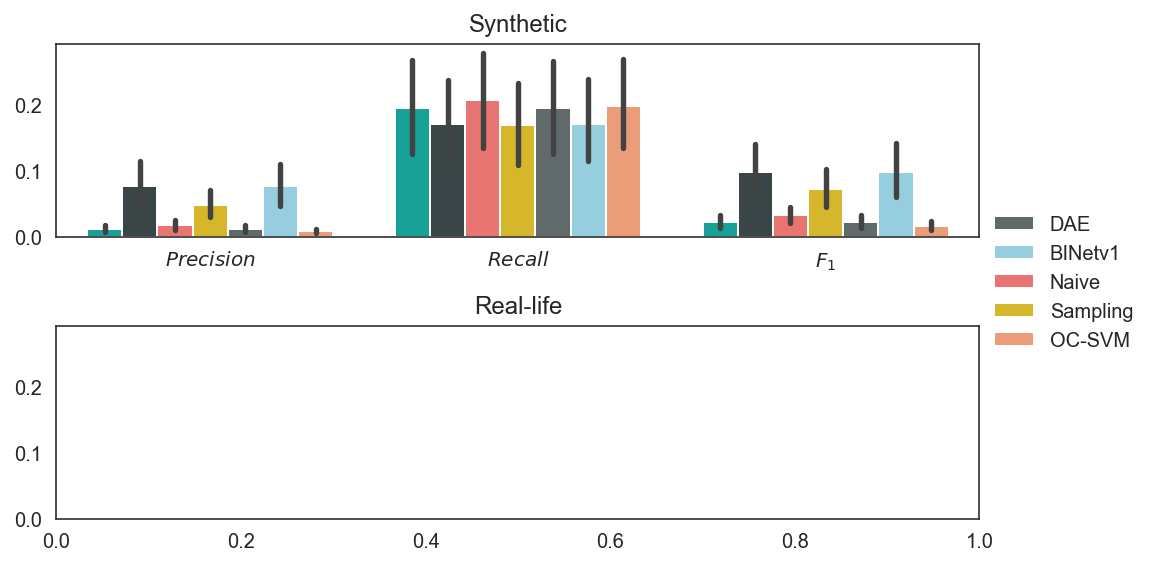

In [28]:
# Set up dataframe
df = filtered_evaluation.query('axis == 2')  # We give results on attribute level
df = prettify_dataframe(df)

# We first have to average for the two perspectives (to always weigh CF and Data 1 to 1), then we can average over all runs and datasets
df = df.groupby(['ad', 'file_name', 'dataset_type', 'dataset_name', 'perspective'])['precision', 'recall', 'f1'].mean().reset_index()
df = df.groupby(['ad', 'file_name', 'dataset_type', 'dataset_name'])['precision', 'recall', 'f1'].mean().reset_index()
df['f1'] = 2 * df['recall'] * df['precision'] / (df['recall'] + df['precision'])  # We recalculate the F1 score based on the new averaged P and R values

# We want to penalize DAE for running out of memory on some of the BPIC datasets, hence we set the F1 score to zero where DAE has NaN values
df = pd.pivot_table(df, index=['ad'], columns=['dataset_type', 'dataset_name'], values=['precision', 'recall', 'f1'])
df = df.fillna(0)
df = df.stack(1).stack(1).reset_index()

# Plot
df = df.melt(id_vars=['ad', 'dataset_type', 'dataset_name'], value_vars=['precision', 'recall', 'f1'], var_name='metric')
df = df.replace('f1', r'$F_1$').replace('precision', r'$Precision$').replace('recall', r'$Recall$')

g = sns.FacetGrid(data=df, row='dataset_type', sharex=False, sharey=True, despine=False, height=2, aspect=3.5, row_order=dataset_types)
g = g.map_dataframe(sns.barplot, x='metric', y='value', hue='ad', palette=microsoft_colors, hue_order=ads, order=[r'$Precision$', r'$Recall$', r'$F_1$'])
g = g.add_legend()

g.axes.flat[0].set(title='Synthetic')
g.axes.flat[1].set(title='Real-life')

g.savefig(str(out_dir / 'eval_overall.pdf'))

## Significance Test (Fig. 11)

Pairwise significance shown in CD diagram (Demsar 2006).

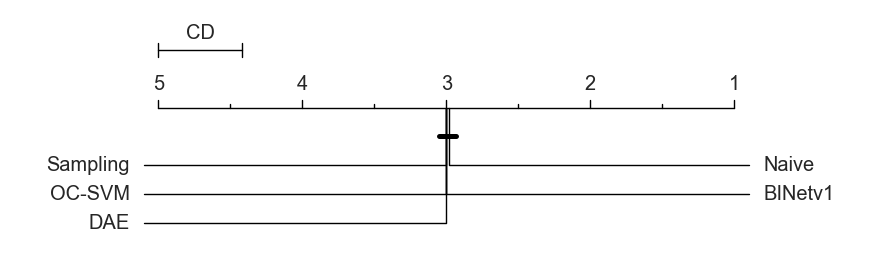

In [10]:
df = filtered_evaluation.query('axis == 2 and dataset_type == "Synthetic"')
df = prettify_dataframe(df)

# We first have to average for the two perspectives (to always weigh CF and Data 1 to 1), then we can average over all runs and datasets
df = df.groupby(['ad', 'file_name', 'dataset_type', 'dataset_name', 'perspective'])['precision', 'recall', 'f1'].mean().reset_index()
df = df.groupby(['ad', 'dataset_type', 'dataset_name'])['precision', 'recall', 'f1'].mean().reset_index()
df['f1'] = 2 * df['recall'] * df['precision'] / (df['recall'] + df['precision'])  # We recalculate the F1 score based on the new averaged P and R values
# df['f1'] = df['f1'].fillna(0)

# We want to penalize DAE for running out of memory on some of the BPIC datasets, hence we set the F1 score to zero where DAE has NaN values
df = pd.pivot_table(df, index=['ad', 'dataset_type'], columns=['dataset_name'], values=['f1'])
df = df.fillna(0)
df = df.stack(1).reset_index()

# Rank by F1 score
df['rank'] = df.groupby(['dataset_name'])['f1'].rank(ascending=False)

k = len(df['ad'].unique())
n = len(df) / k
alpha = 0.05
cd = get_cd(k, n, alpha)  # Critical difference for k groups, n blocks

ranks = df.groupby(['ad'])['rank'].agg(np.mean).dropna().round(2)
fig = cd_plot(ranks, cd=cd, reverse=True)
fig.savefig(str(out_dir / 'significance.pdf'))

Pairwise significance using Nemenyi-Friedman.

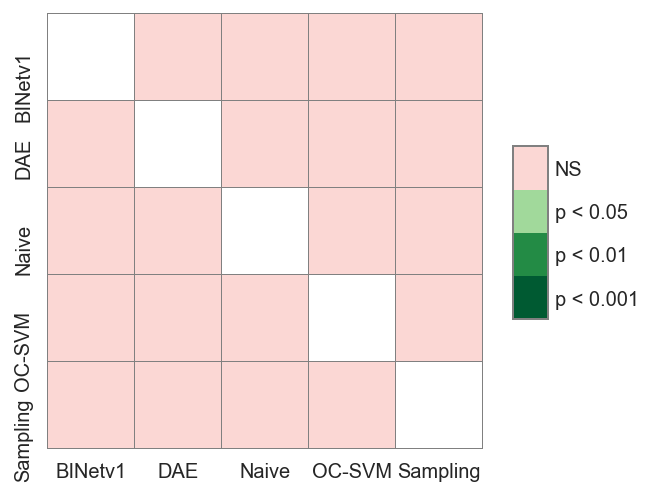

In [11]:
nemenyi_df = df.groupby(['ad', 'dataset_name'])['rank'].mean().dropna().reset_index()
pc = sp.posthoc_nemenyi_friedman(nemenyi_df, y_col='rank', group_col='ad', block_col='dataset_name', melted=True)
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
fig = sp.sign_plot(pc, **heatmap_args)

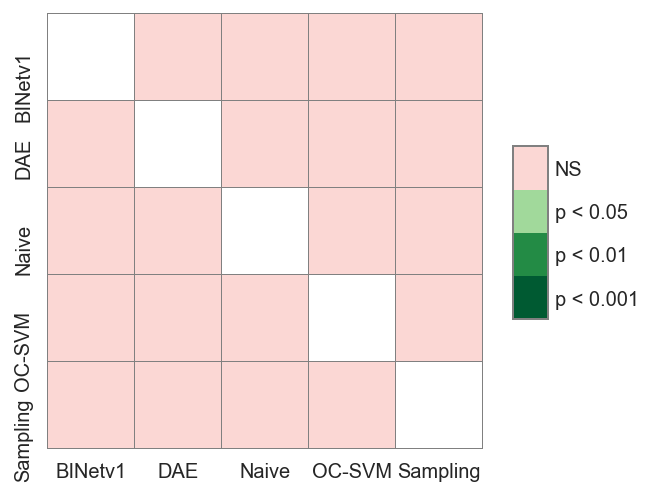

In [12]:
dunn_df = df.groupby(['ad', 'dataset_name'])['rank'].mean().dropna().reset_index()
pc = sp.posthoc_dunn(dunn_df, val_col='rank', group_col='ad', p_adjust='bonferroni')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
fig = sp.sign_plot(pc, **heatmap_args)

## Result table featured in the paper (Table 2)

In [13]:
df = filtered_evaluation.query('axis in [0, 2]')
df = prettify_dataframe(df)
df = df.groupby(['axis', 'process_model', 'dataset_name', 'ad', 'file_name', 'perspective'])['precision', 'recall', 'f1'].mean().reset_index()
df = df.groupby(['axis', 'process_model', 'dataset_name', 'ad', 'file_name'])['precision', 'recall', 'f1'].mean().reset_index()
df['f1'] = 2 * df['recall'] * df['precision'] / (df['recall'] + df['precision'])

df = pd.pivot_table(df, index=['axis', 'ad'], columns=['process_model', 'dataset_name'], values=['precision', 'recall', 'f1'])
df = df.fillna(0)
df = df.stack(1).stack(1).reset_index()
df.to_excel(str(out_dir / 'table.xlsx'), index=False)

df = pd.pivot_table(df, index=['axis', 'ad'], columns=['process_model'], values=['f1'], aggfunc=np.mean)
df.round(2)

f1  \
process_model      huge-0.3-1_binetv1_20200201-165817.760446.model   
axis      ad                                                         
Attribute BINetv1                                             0.64   
          DAE                                                 0.00   
          Naive                                               0.00   
          OC-SVM                                              0.00   
          Sampling                                            0.00   
Case      BINetv1                                             0.77   
          DAE                                                 0.00   
          Naive                                               0.00   
          OC-SVM                                              0.00   
          Sampling                                            0.00   

                                                                \
process_model      huge-0.3-1_dae_20200201-165551.164305.model   
axis      ad                                                     
Attribute BINetv1                                         0.00   
          DAE                                             0.25   
          Naive                                           0.00   
          OC-SVM                                          0.00   
          Sampling                                        0.00   
Case      BINetv1                                         0.00   
          DAE                                             0.57   
          Naive                                           0.00   
          OC-SVM                                          0.00   
          Sampling                                        0.00   

                                                                  \
process_model      huge-0.3-1_naive_20200201-165545.655035.model   
axis      ad                                                       
Attribute BINetv1                                           0.00   
          DAE                                               0.00   
          Naive                                             0.24   
          OC-SVM                                            0.00   
          Sampling                                          0.00   
Case      BINetv1                                           0.00   
          DAE                                               0.00   
          Naive                                             0.85   
          OC-SVM                                            0.00   
          Sampling                                          0.00   

                                                                          \
process_model      huge-0.3-1_one-class-svm_20200201-165527.425465.model   
axis      ad                                                               
Attribute BINetv1                                                0.00      
          DAE                                                    0.00      
          Naive                                                  0.00      
          OC-SVM                                                 0.19      
          Sampling                                               0.00      
Case      BINetv1                                                0.00      
          DAE                                                    0.00      
          Naive                                                  0.00      
          OC-SVM                                                 0.72      
          Sampling                                               0.00      

                                                                     \
process_model      huge-0.3-1_sampling_20200201-165546.769057.model   
axis      ad                                                          
Attribute BINetv1                                              0.00   
          DAE                                                  0.00   
          Naive                                                0.